## Microblock Buffering Study

Divisions of a block are created before the block is sent out. These divisions are called microblocks - groups of transactions that can be executed in parallel. Agave calls these microblocks "entries." These divisions are logical and necessary, for when a microblock is recieved, a validator can begin replaying those transactions without needing to wait for the entire block. 

Functionally, in firedancer, as these microblocks are produced they are slowly accumulated in a buffer of size `N`. And when no more microblocks can fit into the buffer, the entire buffer is shredded and dispersed to the network. All the shreds produced from this one iteration of buffer is referred to as a "batch." A batch contains a whole number of microblocks and whole number of shreds, but each microblock isn't necessarily composed of a whole number of shreds. 
```
|  buffer                                                                  |
| microblock 1 (small) | microblock 2 (iiiig -----------) | 000 (padding)  |
| shred 1 | shred 2 | shred 3 | shred 4 | shred 5 | shred...... | shred 32 |
```
```
|  buffer                                                                                   |
| microblock 1 (small) | microblock 2 (biiiiiiiiiiiiiiiig -------)  00000000000000000000000 |
| shred 1 | shred 2 | shred 3 | shred 4 | ......... | shred 36 | shred 37 | .... | shred 47 |
```

```
|  buffer (bigger)                                                                          |
| microblock 1 (small) | ... | microblock 4 (biiiiiiiiiiiiiiiiiiiig -----------) 0000000000 |
| shred 1 | ... | shred 32 | shred 1 | ... | shred 32 | shred 1 | shred 2 |..... | shred 47 |
| FEC set 1 of 32 shreds   | FEC set 2 of 32 shreds   | FEC set 2 of 47 shreds              |
```


Both Agave and firedancer TARGET 32 shreds per batch, but in the current status quo, we can produce any number of shreds per buffer. The number of shreds produced is dependent on how much data is in the buffer.

This is unfortunate because in order to detect equivocation -- in particular, if a producer has tacked on transactions in an extra shred or removed transactions, we rely on information related to the number of shreds in a batch. 
In `fd_eqvoc.h::fd_eqvoc_fec_search` we check if a FEC set overlaps with another FEC set. All data shreds have a fec_set_idx and data_cnt. In the last example above, it would be
```
| fec_set_idx: 0   |  fec_set_idx: 32   |  fec_set_idx: 64
| data_cnt: 32     |  data_cnt:32       |  data_cnt: 47
```

If any of the indexes overlap, then we know that two versions of the previous or current FEC set have been produced. We can check for this overlap both backwards and forwards.  We know 
the max number of data shred idxs in a valid FEC set is 67.  So we need to look back at most 67 FEC set idxs to find the previous FEC set, and do the same looking forward.

This is complicates the protocol, and can be made much simpler by fixing FEC sets to size 32. Then, if fec_set_idxs are not a multiple of 32, we can already immediately assume that a block producer has tacked on
or removed a shred. By fixing a buffer to a multiple of a FEC set N=32 size though, we may incur some penalty on how much padding we need to add per batch (which wastes network bandwidth). The stuff below tries to find optimal buffer size that
is fixed to a multiple of the OPT_FEC_SZ (31840 = 32 * 995), that minimizes the padding added + latency increase.

In [1]:
import pandas as pd
import numpy as np

microblock_df = pd.read_csv('microblocks.csv', 
                            dtype={'slot': int, 'batch_idx': int, 'ref_tick': int, 'hashcnt_from_start' : int, 'sz': int, 'txn_cnt': int},
                           )
batch_df = pd.read_csv('batch.csv')
print("Microblock df: ")
print(microblock_df.head(), "\n")
print("Batch df: ")
print(batch_df.head(), "\n")

# stats on microblocks per slot:
print("Number of Microblocks per slot stats:")
slot_stats = microblock_df.groupby('slot').size().describe()
print(slot_stats)

slot_count = microblock_df['slot'].nunique()
print("Number of slots: ", slot_count)
assert(slot_count == batch_df['slot'].nunique())


Microblock df: 
        slot  batch_idx  ref_tick  hash_count_from_start    sz  txn_cnt
0  308015637          0         6                  20225   379        1
1  308015637          0         6                  21442  1148        1
2  308015637          0         6                  23875  5471       17
3  308015637          0         6                  29444   851        2
4  308015637          0         6                  41861   367        1 

Batch df: 
        slot  ref_tick     sz  shred_cnt
0  308015637         6  34774         36
1  308015637        12  35169         37
2  308015637        19  33969         35
3  308015637        28  30219         31
4  308015637        36  35150         37 

Number of Microblocks per slot stats:
count    4830.000000
mean      474.599586
std       207.442792
min        64.000000
25%       379.000000
50%       435.000000
75%       516.000000
max      3425.000000
dtype: float64
Number of slots:  4830


## Pre-processing

The `hashcnt_from_start` is the cumulative sum of the `hashcnt_delta` field in each microblock header.
We try to use  `hashcnt_from_start` as a general mark of when the microblock was ready to be published - which is generally several ticks earlier than the `ref_tick` as it takes 
some time for the the batch buffer to accumulate microblocks before beginning shredding. 

Looking at `fd_poh.c`, it's generally correct. The `hashcnt_delta` is populated when `publish_microblock` is called, and it creates the delta from the `ctx`'s current hashcnt. If we look at the microblocks data, GENERALLY, if `hc` is the last microblock's `hashcnt_from_start` of each batch, then the `ref_tick` of that batch is `hc`/62500. 

This has some exceptions, when we mix in ticks. If a slot is skipped then the leader needs to provide the extra 64x(skipped slots) ticks for the proof of skip. We pre-process it below

Aside: Ticks in general have their hashcnt delta generated by getting whenever the PREVIOUS microblock was sent, and rounding it up to the next 62500 boundary. 

Microblock:

`hashcnt_delta = ctx->hashcnt - ctx->last_hashcnt;`                             -> dependent on last microblock sent hashcnt 

`meta->ref_tick = (ctx->hashcnt/ctx->hashcnt_per_tick) % ctx->ticks_per_slot;`  -> dependent on only the contexts hashcount

Tick:

`ulong hashcnt = ctx->hashcnt_per_tick*(1UL+(ctx->last_hashcnt/ctx->hashcnt_per_tick));`  -> dependent on last microblock sent hashcnt
 - getting the hashcount of the last microblock sent, and rounding it up to a multiple of 62500 

`meta->ref_tick = hashcnt/ctx->hashcnt_per_tick;`                          -> dependent on last microblock sent hashcnt

`ulong hash_delta = hashcnt - ctx->last_hashcnt;`                          -> dependent on last microblock sent hashcnt

So in general, the microblocks hashcnt_from_start will be accurate. TICKS reported hashcnt_from_start vs. actual hashcount ready is likely off, but we don't care.

In [37]:
"""
We have two measures of time: ref_tick and hashcnt_from_start.
ref_tick is the tick where the batch is shredded. So all microblocks in the same batch have the same ref_tick, but will have been accumulated in the buffer
at or before that ref_tick. 

A more fine-grained measure of time we have is hashcnt_from_start. This is the number of hashes that has been done since the start of the slot
up until when this microblock was ready. We verified that these hashcnts always end at 4mil, which is the number of hashes in a slot. The only exception
is when slots have been skipped, and the leader needed to provide proof-of-skip hashes - in this case the hashcnt_from_start will end at 4000000 + 4000000*number_of_skipped_slots.,
but will always be a perfect multiple of 4M. In these cases, we should just zero out any of these proof-of-skip hashes, as they are should be ready at the start of the slot.


Preprocessing steps:
Find all slots with more than 64 ticks. 
1) verify that the slot then has a multiple of 64 ticks
2) find the number of ticks before the first hash
3) zero out the hashcnts for the ticks that are skip ticks, and adjust the hashcnts for the rest of the microblocks

All the proof of skip ticks are packed first, before ANY of the ticks / microblocks for the current slot are packed.
verified - in fd_poh.c in the publish_tick() call in after_credit()
"""
print(microblock_df['slot'].unique())
microblock_df['hashcnt_adj'] = microblock_df['hash_count_from_start']

for i, slot in enumerate(microblock_df['slot'].unique()):
    slot_with_extra_hashes = microblock_df[microblock_df['slot'] == slot]
    ticks = slot_with_extra_hashes[slot_with_extra_hashes['txn_cnt'] == 0]
    num_ticks = len(ticks)
    num_skip_ticks = num_ticks - 64

    assert(num_ticks % 64 == 0)
    if num_ticks == 64: continue     # no slots were skipped

    ticks_before_first_mblk = 0

    # sanity check
    for idx, row, in slot_with_extra_hashes.iterrows():
        if row['txn_cnt'] > 0:
            assert( len(ticks) - ticks_before_first_mblk <= 64)
            break
        ticks_before_first_mblk += 1
    
    # Now we want to actually zero out the timestamps for the ticks that are skip ticks. 
    # These are sent in the first ref_tick anyway, and are ready immediately.

    # set the first x rows of slot_with_extra_hashes['ref_tick'] to 0.
    col_idx = slot_with_extra_hashes.columns.get_loc('hashcnt_adj')
    slot_with_extra_hashes.iloc[:num_skip_ticks, col_idx] = 0

    # set the rest of the rows to itself - num_skip_ticks * 62500
    slot_with_extra_hashes.iloc[num_skip_ticks:, col_idx] = slot_with_extra_hashes.iloc[num_skip_ticks:, col_idx] - num_skip_ticks * 62500

    # apply it to the original dataframe
    microblock_df.loc[microblock_df['slot'] == slot, 'hashcnt_adj'] = slot_with_extra_hashes['hashcnt_adj']
    
#print(" slot 308015760 ", microblock_df[microblock_df['slot'] == 308015760].to_string())



[308015637 308015638 308015639 ... 308020635 308020636 308020637]


In [3]:
"""
Preprocessing:
1) The last microblock(s) of a slot could have ref_tick = 0, as per the spec. It seems that it's not only just the last shred
that has ref_tick = 0, but it could also be all the shreds in the last batch ( tested in fd_blockstore_ctl ). Thus, we can't
forward fill the ref_tick values in the last batch, to get the actual ref_tick. So instead we manually set ref_tick = 64 for
the microblocks in the last batch of the slot.
"""
last_row_per_slot = batch_df.groupby('slot').tail(1)
for idx, row in last_row_per_slot.iterrows():
    batch_df.loc[idx, 'ref_tick'] = 64

last_row_per_slot = microblock_df.groupby('slot').tail(1)
for idx, row in last_row_per_slot.iterrows():
    microblock_df.loc[idx, 'ref_tick'] = 64
    while ( microblock_df.loc[idx - 1, 'ref_tick'] == 0 ):
        microblock_df.loc[idx - 1, 'ref_tick'] = 64
        idx = idx - 1

print(batch_df[1399:1405])
print(microblock_df[2775:2790])

           slot  ref_tick     sz  shred_cnt
1399  308015698        57  42491         44
1400  308015698        64   3901         32
1401  308015699         0  36169         38
1402  308015699         1  33661         35
1403  308015699         4  34685         36
1404  308015699         6  34525         36
           slot  batch_idx  ref_tick  hash_count_from_start     sz  txn_cnt  \
2775  308015643         18        62                3875065   8023       25   
2776  308015643         19        64                3879546   4666        6   
2777  308015643         19        64                3889595   4514       14   
2778  308015643         19        64                3893052   1794        2   
2779  308015643         19        64                3899261   1088        1   
2780  308015643         19        64                3905534   1088        1   
2781  308015643         19        64                3915391   7704       24   
2782  308015643         19        64                3934400 

In [4]:
"""
Sanity checks
"""
def hashcnt_to_tick( hashcnt ):
    return (int) (hashcnt / 62500)

# Sanity check the microblocks with txn count 0
result = microblock_df.groupby('slot')['txn_cnt'].apply(lambda x:(x == 0).sum())
# print slots where number of empty txns is != 64
print(result[ result != 64 ])

"""
As expected, the number of microblocks with 0 txn cnt per slot is always multiple of 64. Verifying we produce a tick
microblock 64 times a slot. 
"""

print('Total microblocks with 0 txn count: ', microblock_df[microblock_df['txn_cnt'] == 0]['txn_cnt'].count())

# check that last batch in each slot has a microblock with txn_cnt = 0
last_batch_per_slot = microblock_df.groupby('slot')['batch_idx'].max()
for slot, batch_idx in last_batch_per_slot.items():
    last_microblocks = microblock_df[(microblock_df['slot'] == slot) & (microblock_df['batch_idx'] == batch_idx)]
    last_microblocks = last_microblocks[last_microblocks['txn_cnt'] == 0]
    assert(len(last_microblocks) > 0)


# check that for each microblock, ref_tick matches hashcount
for idx, row in microblock_df.iterrows():
    assert(row['ref_tick'] >= hashcnt_to_tick(row['hashcnt_adj']))

# sanity check the very first size of microblocks 
first_batch_sz = microblock_df[(microblock_df['slot'] == 308015637) & (microblock_df['batch_idx'] == 0)]['sz'].sum() 
print("First batch size: ", first_batch_sz, " should be -8 from first batch size in batch_df: ", batch_df.iloc[0]['sz'])
assert(first_batch_sz == batch_df.iloc[0]['sz'] - 8)

slot
308015760    320
308015872    320
308016005    128
308016024    320
308016040    320
308016100    320
308016132    320
308016152    320
308016173    128
308016180    320
308016192    320
308016200    320
308016212    320
308016252    320
308016292    320
308016476    320
308016489    128
308016540    320
308016556    320
308016568    320
308016588    320
308016596    320
308016640    320
308016680    320
308016720    320
308016772    320
308016800    320
308016824    320
308016836    320
308016873    128
308016900    320
308016944    320
308017104    320
308017832    320
308018068    320
308018516    320
308018692    320
308018704    320
308018752    320
308018848    320
308018972    320
308019452    320
308020068    320
308020073    128
308020116    320
308020176    320
308020213    192
Name: txn_cnt, dtype: int64
Total microblocks with 0 txn count:  320064
First batch size:  34766  should be -8 from first batch size in batch_df:  34774


## Preliminary EDA



In [5]:
summary = microblock_df.describe()
print(summary)
summary = batch_df.describe()
print(summary)

def ref_tick_to_timestamp( min_slot, slot, ref_tick):
    tick_sz = 400.0 / 64.0
    return ref_tick * tick_sz + (( slot - min_slot ) * 400.0 ) 

# transform ref_tick to timestamp
min_slot = microblock_df['slot'].min()
print(min_slot)

microblock_df['timestamp'] = microblock_df.apply(lambda row: ref_tick_to_timestamp(min_slot, row['slot'], row['ref_tick']), axis=1)
batch_df['timestamp']      = batch_df.apply(lambda row: ref_tick_to_timestamp(min_slot, row['slot'], row['ref_tick']), axis=1)


               slot     batch_idx      ref_tick  hash_count_from_start  \
count  2.292316e+06  2.292316e+06  2.292316e+06           2.292316e+06   
mean   3.080182e+08  1.230839e+01  2.606549e+01           1.759344e+06   
std    1.461776e+03  8.075139e+00  1.697287e+01           2.002861e+06   
min    3.080156e+08  0.000000e+00  0.000000e+00           6.500000e+01   
25%    3.080169e+08  5.000000e+00  1.200000e+01           7.174108e+05   
50%    3.080182e+08  1.200000e+01  2.300000e+01           1.437566e+06   
75%    3.080195e+08  1.800000e+01  3.800000e+01           2.304468e+06   
max    3.080206e+08  5.700000e+01  6.400000e+01           2.000000e+07   

                 sz       txn_cnt   hashcnt_adj  
count  2.292316e+06  2.292316e+06  2.292316e+06  
mean   1.729417e+03  3.934705e+00  1.557802e+06  
std    3.407608e+03  1.046365e+01  1.023186e+06  
min    4.800000e+01  0.000000e+00  0.000000e+00  
25%    3.670000e+02  1.000000e+00  6.973570e+05  
50%    8.500000e+02  1.000000e+00

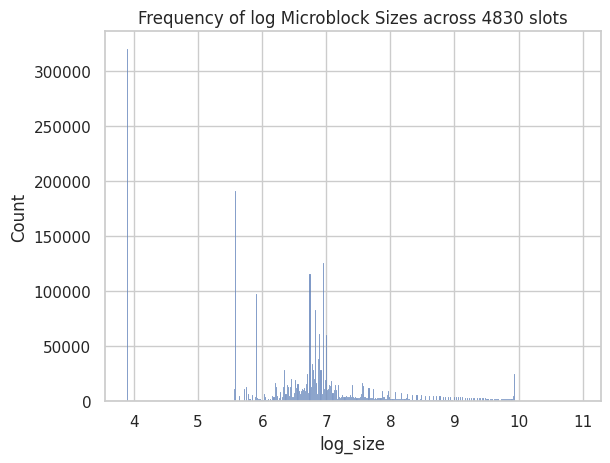

In [6]:
#graph microblock sizes
import matplotlib.pyplot as plt
import seaborn as sns

microblock_df['log_size'] = np.log( microblock_df['sz'] + 1 )  

sns.set( style="whitegrid" )
#fig, axes = plt.subplots(1, 1, figsize=(16, 6))

# side by side plots
sns.histplot( x='log_size', data=microblock_df )#, ax=axes[0])
plt.title(f'Frequency of log Microblock Sizes across {slot_count} slots')
plt.show()

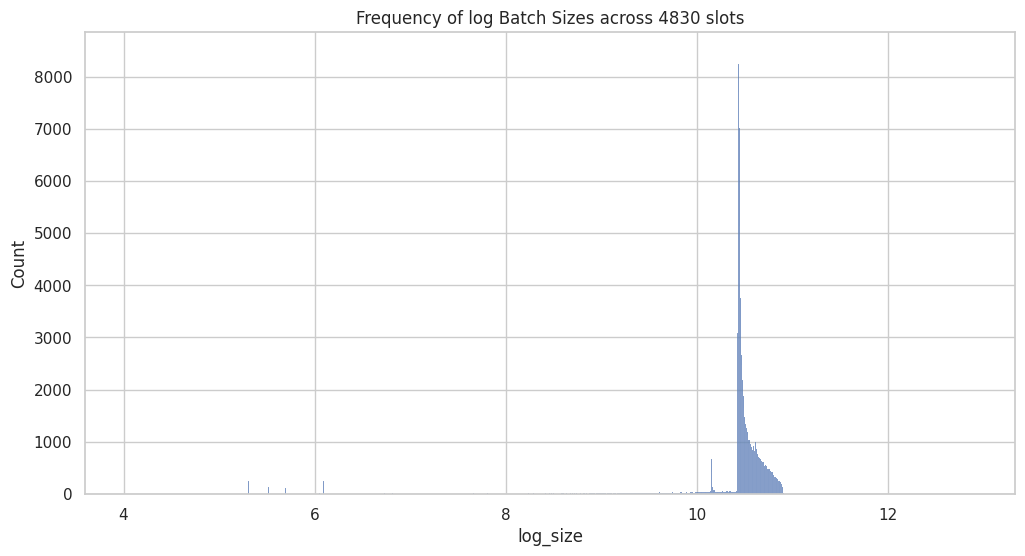

In [7]:
# plot batch sizes
batch_df['log_size'] = np.log(batch_df['sz'] + 1)

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.histplot(x='log_size', data=batch_df)
plt.title(f'Frequency of log Batch Sizes across {slot_count} slots')
plt.show()

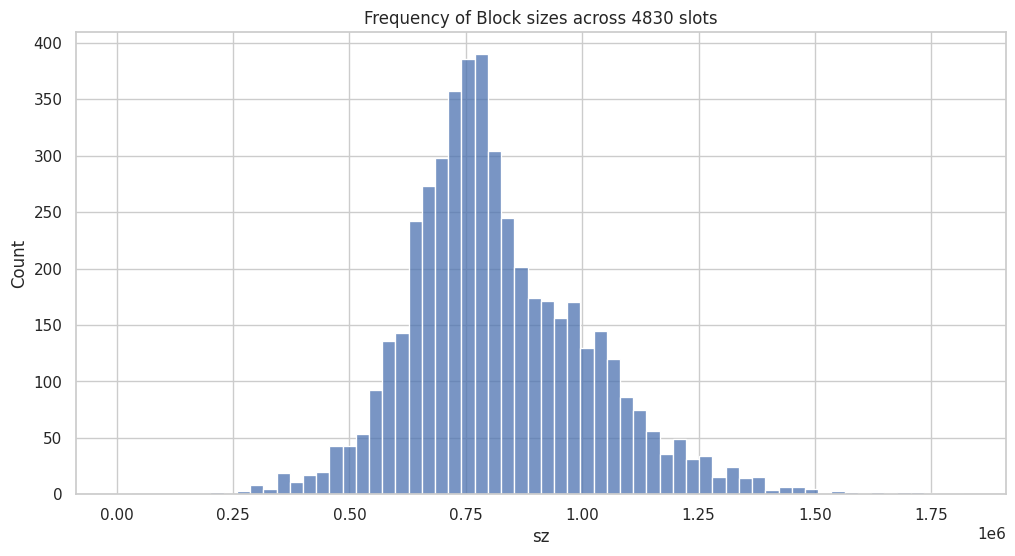

In [8]:
#graph block sizes

slot_level_info = microblock_df.groupby('slot', as_index=False).sum()

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.histplot(x='sz', data=slot_level_info)
plt.title(f'Frequency of Block sizes across {slot_count} slots')
plt.show()

# relevant for later -- we want to bin the blocks into 3 categories: small, medium, large
# so we can compare how microblockss get accumulated with similar block sizes.
block_sz_q1 = slot_level_info['sz'].quantile(0.25)
block_sz_q2 = slot_level_info['sz'].quantile(0.75)

count    113719.000000
mean         17.590398
std          35.153396
min           0.000000
25%           6.250000
50%          12.500000
75%          18.750000
max        1956.250000
Name: time_diff, dtype: float64


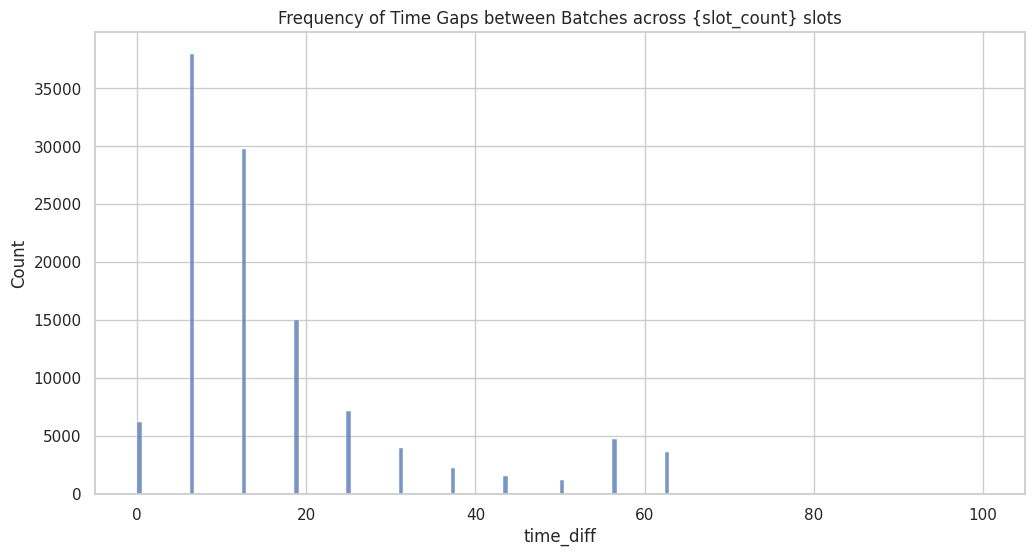

In [9]:
# time gaps between batches sent out
batch_df['time_diff'] = batch_df['timestamp'].diff()

print(batch_df['time_diff'].describe())
 
# drop outliers
Q1 = batch_df['time_diff'].quantile(0.10)
Q3 = batch_df['time_diff'].quantile(0.90)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
batch_df_filtered = batch_df[(batch_df['time_diff'] >= lower_bound) & (batch_df['time_diff'] <= upper_bound)]

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.histplot(x='time_diff', data=batch_df_filtered)
plt.title('Frequency of Time Gaps between Batches across {slot_count} slots')
plt.show()

## Simulate

Current Scheme:

In Agave, it sets a timer to wait for more entries if the number of entries is not enough yet, and sends out entries when the timer is up OR if we've hit the OPT_FEC_SZ. Whichever is earlier. This means frequently, Agave is sending out batches with > 32 shreds, but with only one FEC set. 
- This happens `recv_slot_entries` - it targets accumulating OPT_FEC_SZ bytes of entries. 

In Agave `make_shreds_from_data` is shredding happens. The shredder breaks off OPT_FEC_SZ chunks until the total data size < 2* OPT_FEC_SZ (unless data size % OPT_FEC_SZ = 0, in which case it'll just evenly break up all the chunks ), and then makes an oddly sized FEC set out of the remainder. If remainder shred is the last in the block, and is smaller than 32 shreds, it'll pad to 32 shreds. Same behavior happens in firedancer.

New Scheme:

Entries are accumulated in a buffer. Only when the buffer is at capacity, entries are sent. If a microblock was added that does not fit in the buffer, that microblock is saved for the next batch. This is what we simulate in `simulate_packing`

In [10]:
OPT_FEC_SZ = 31840

def simulate_packing( buf_sz, microblock_df, verbose=False):
    slots = microblock_df['slot'].unique()
    slots.sort()

    total_padding_used = 0
    total_mblk_wait_time = 0
    padding_by_slot = {}
    mblk_wait_by_slot = {}
    negative_latencies = 0
    block_accum_by_slot = {} # slot: ([t1, t2, t3 ... ], [sz1, sz2, ... sz_done]) where time is increasing

    for slot in slots:
        padding_by_slot[slot]     = []
        mblk_wait_by_slot[slot]   = []
        block_accum_by_slot[slot] = ([], [])

        # Iterating by microblocks per slot for now, as per slot info might be useful
        microblocks = microblock_df[microblock_df['slot'] == slot]
        batch       = []
        cur_sz      = 8  # Each batch starts with 8 bytes saved for microblock cnt
        accum_sz    = 0
        for _, row in microblocks.iterrows():
            if cur_sz + row['sz'] <= buf_sz:    
                # If microblock fits in buffer, add it to batch
                cur_sz += row['sz']
                batch.append(row)
            else:
                # Send out batch
                tick_sent = hashcnt_to_tick(batch[-1]['hashcnt_adj'])
                accum_sz += cur_sz

                block_accum_by_slot[slot][0].append(tick_sent)
                block_accum_by_slot[slot][1].append(accum_sz)

                for b in batch:
                    b_ready = hashcnt_to_tick(b['hashcnt_adj'])
                    total_mblk_wait_time += tick_sent - b_ready
                    if tick_sent < b_ready: negative_latencies += tick_sent - b_ready
                    mblk_wait_by_slot[slot].append(tick_sent - b_ready)

                # only send up to tightest fitting multiple of OPT_FEC_SZ
                multiple = (int) (buf_sz / OPT_FEC_SZ)
                for i in range(1, multiple):
                    if cur_sz <= i * OPT_FEC_SZ:
                        buf_sz = i * OPT_FEC_SZ
                        break
                    
                total_padding_used += buf_sz - cur_sz
                padding_by_slot[slot].append(buf_sz - cur_sz)
                # Refill buffer
                buf_sz = multiple * OPT_FEC_SZ
                cur_sz = row['sz'] + 8
                batch  = [row]
        
        # Send out last buffer/batch
        multiple = (int) (buf_sz / OPT_FEC_SZ)
        for i in range(1, multiple):
            if cur_sz <= i * OPT_FEC_SZ:
                buf_sz = i * OPT_FEC_SZ
                break

        total_padding_used += buf_sz - cur_sz
        padding_by_slot[slot].append(buf_sz - cur_sz)
        tick_sent = hashcnt_to_tick(batch[-1]['hashcnt_adj'])
        accum_sz += cur_sz
        block_accum_by_slot[slot][0].append(tick_sent)
        block_accum_by_slot[slot][1].append(accum_sz)
        #tick_sent = min( hashcnt_to_tick(batch[-1]['hashcnt_adj']), batch[-1]['ref_tick'] )
        for b in batch:
            b_ready =  hashcnt_to_tick(b['hashcnt_adj'])
            total_mblk_wait_time += tick_sent - b_ready
            if tick_sent < b_ready: negative_latencies += tick_sent - b_ready
            mblk_wait_by_slot[slot].append(tick_sent - b_ready)
        
        buf_sz = multiple * OPT_FEC_SZ # reset buf_sz for next slot
    
    return total_padding_used, padding_by_slot, total_mblk_wait_time, mblk_wait_by_slot, block_accum_by_slot, negative_latencies



In [11]:
PAY_SZ   = 995 
buf_szes = [
    PAY_SZ * 32,
    PAY_SZ * 32 * 2,
    PAY_SZ * 32 * 3,
    PAY_SZ * 32 * 4,
    PAY_SZ * 32 * 5,
    PAY_SZ * 32 * 6,
    PAY_SZ * 32 * 7,
]

bufs_padding_lst = []
bufs_latency_lst = []
padding_by_slot_by_buf = {}
latency_by_slot_by_buf = {}
block_accum_by_slot_by_buf = {}

for buf_sz in buf_szes:
    print('Buffer size: ', buf_sz)
    total_padding_used, padding_by_slot, total_mblk_wait_time, mblk_wait_by_slot, block_accum_by_slot, negative_latencies = simulate_packing( buf_sz, microblock_df )
    bufs_padding_lst.append(total_padding_used)
    bufs_latency_lst.append(total_mblk_wait_time)
    padding_by_slot_by_buf[buf_sz] = padding_by_slot
    latency_by_slot_by_buf[buf_sz] = mblk_wait_by_slot
    block_accum_by_slot_by_buf[buf_sz] = block_accum_by_slot
    print('Total padding used: ', total_padding_used)
    print('Total mblk_wait_time: ', total_mblk_wait_time)
    print('Negative latencies?: ', negative_latencies)

prev = """
For using ref_tick granularity for latency
Buffer size:  31840
Total padding used:  698030933.0
Total latency increase:  3148245.0
Buffer size:  63680
Total padding used:  352200325.0
Total latency increase:  6420717.0
Buffer size:  95520
Total padding used:  248874229.0
Total latency increase:  9446169.0
Buffer size:  127360
Total padding used:  198656869.0
Total latency increase:  12346015.0
Buffer size:  159200
Total padding used:  171454797.0
Total latency increase:  15290207.0
Buffer size:  191040
Total padding used:  155186821.0
Total latency increase:  17964456.0
"""

Buffer size:  31840
Total padding used:  698030933.0
Total mblk_wait_time:  4293134
Negative latencies?:  0
Buffer size:  63680
Total padding used:  352200325.0
Total mblk_wait_time:  7650190
Negative latencies?:  0
Buffer size:  95520
Total padding used:  248874229.0
Total mblk_wait_time:  10698986
Negative latencies?:  0
Buffer size:  127360
Total padding used:  198656869.0
Total mblk_wait_time:  13722086
Negative latencies?:  0
Buffer size:  159200
Total padding used:  171454797.0
Total mblk_wait_time:  16632453
Negative latencies?:  0
Buffer size:  191040
Total padding used:  155186821.0
Total mblk_wait_time:  19338577
Negative latencies?:  0
Buffer size:  222880
Total padding used:  141775413.0
Total mblk_wait_time:  22086258
Negative latencies?:  0


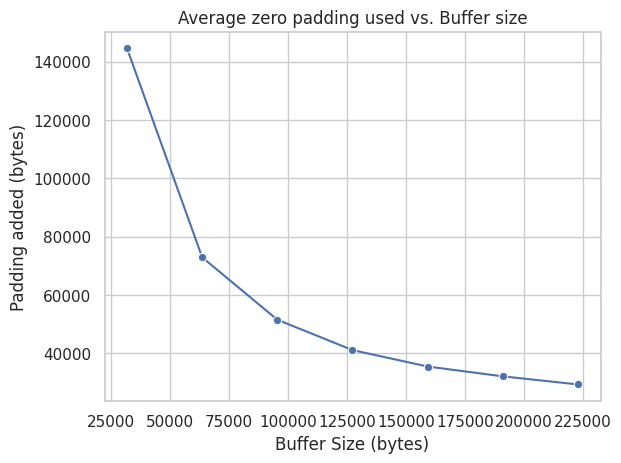

In [12]:
# average padding per slot
slot_count = microblock_df['slot'].nunique()
padding_per_slot = [ pad / slot_count for pad in bufs_padding_lst]

sns.set(style="whitegrid")
sns.lineplot(x=buf_szes, y=padding_per_slot, marker='o')

plt.xlabel('Buffer Size (bytes)')
plt.ylabel('Padding added (bytes)')
plt.title('Average zero padding used vs. Buffer size')
plt.show()

As expected, zero padding required decreases to almost negligible amounts as buffer size increases. If we are doing aggressive buffering (smaller buffer size), we send out batches much more frequently with zero padding at the end, because we may frequently run into the case where a microblock 
cannot fit into the end remaining space in the buffer. If we have an extremely large buffer, we are able to tightly pack all the microblocks next to each other until the entire block is packed into one buffer, and only pack 0s to the next tightest multiple of OPT_FEC_SZ above that. So the zero padding 
occurs only once in the entire block/slot. This is expressed by the curve flattening exponentially as the buffer size increases, and behavior of the simulation matches what we expect.

The tradeoff of having an extremely large buffer is that microblocks are no longer streamed - the entire block is shredded at tick 64, which is highly unideal for other validators to recieve and replay. We expect that as the buffer size increases, latency of block dissemination should increase naturally, as we have to wait longer
for the buffer to fill up before we can begin shredding. 

## Latency

We measure latency in 2 ways:

1. Microblock wait time - time the microblock spends between being ready (it's `hashcnt_from_start`) to when it is shredded (the `ref_tick`)
2. Percentage of block sent out by a tick n

    a. Also, at fixed ticks, percent of block sent.

    b. Almost all blocks will send out their last batch at 64 because of the 64th tick always being shredded last, but for large buffers, there may be no shredding occuring until midway through the slot (ex. one batch at t=32, one batch at t=64), which is also not ideal


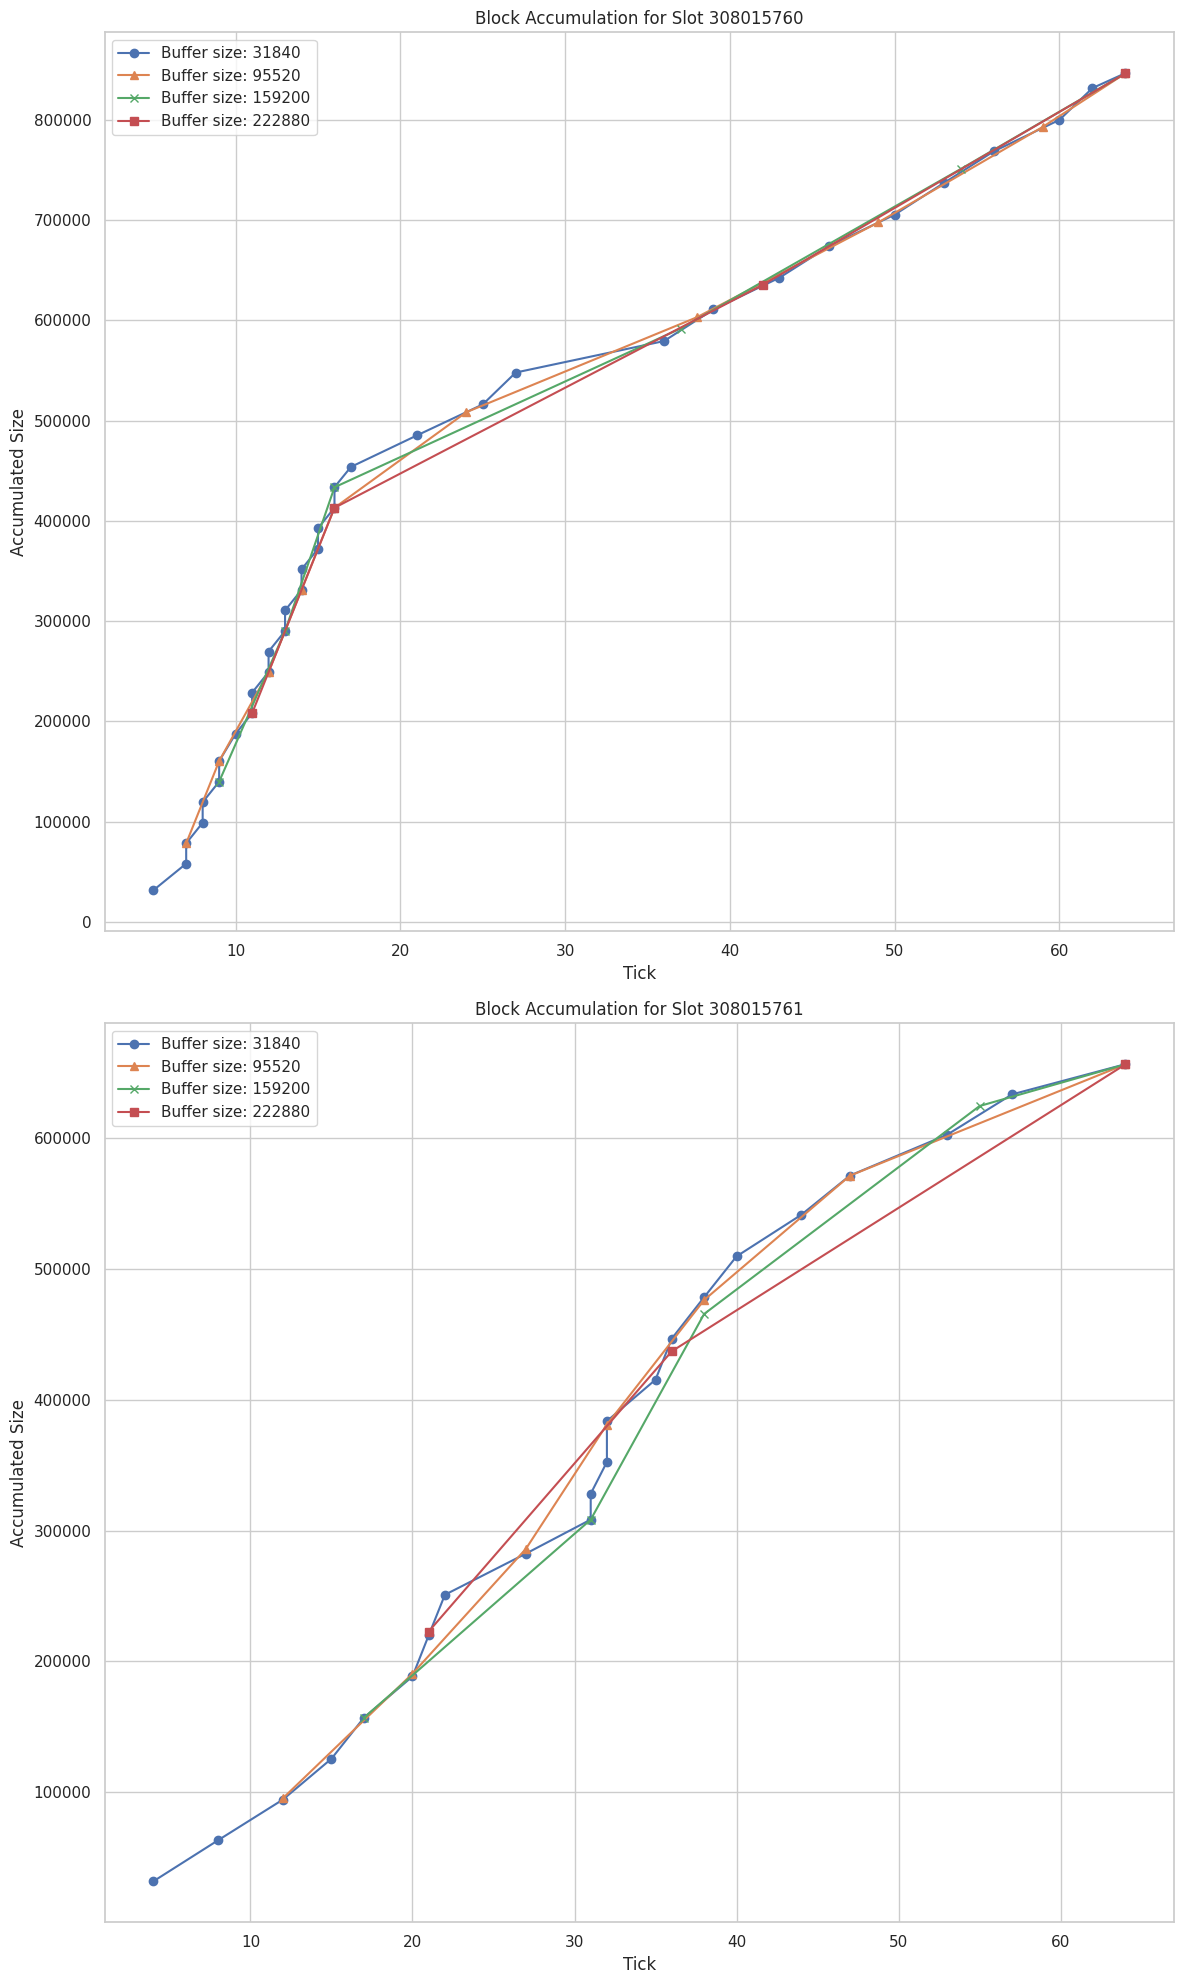

In [13]:
# pick several slots to compare the block accumulation - but more useful to be comparing this against the current scheme

slots = [308015760, 308015761] #, 308015762, 308015763, 308015764, 308015765, 308015766, 308015767, 308015768, 308015769]

fig, axes = plt.subplots(len(slots), 1, figsize=(12, 10 * len(slots))) 
axes = axes.flatten()
markers = ['o', 's', '^', 'd', 'x']  

for i, slot in enumerate(slots):
    for j, buf in enumerate(buf_szes):
        if j % 2 == 1: continue 
        # skip every other buffer size - othw very cluttered
        axes[i].plot(block_accum_by_slot_by_buf[buf][slot][0], block_accum_by_slot_by_buf[buf][slot][1], marker=markers[j % len(markers)], label=f'Buffer size: {buf}')
    
    axes[i].set_title(f'Block Accumulation for Slot {slot}')
    axes[i].set_xlabel('Tick')
    axes[i].set_ylabel('Accumulated Size')
    axes[i].legend()

plt.tight_layout()
plt.show()


As expected, for larger buffer sizes, the first batch shreds later and later into the slot, and the jump between batches is much larger.

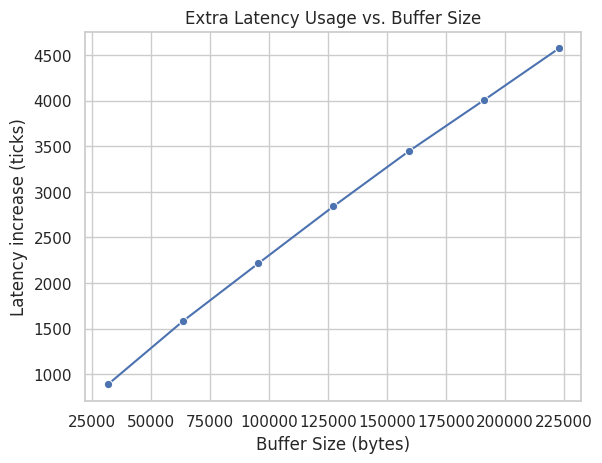

In [14]:
latency_per_slot = [ lat / slot_count for lat in bufs_latency_lst]

sns.set(style="whitegrid")
sns.lineplot(x=buf_szes, y=latency_per_slot, marker='o')

plt.xlabel('Buffer Size (bytes)')
plt.ylabel('Latency increase (ticks)')
plt.title('Extra Latency Usage vs. Buffer Size')
plt.show()

The microblock wait time (in ticks) increases linearly with the buffer size. We later discuss the scale / multipliers.

/tmp/ipykernel_960583/3210413459.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(values, labels=labels, vert=True, patch_artist=True)


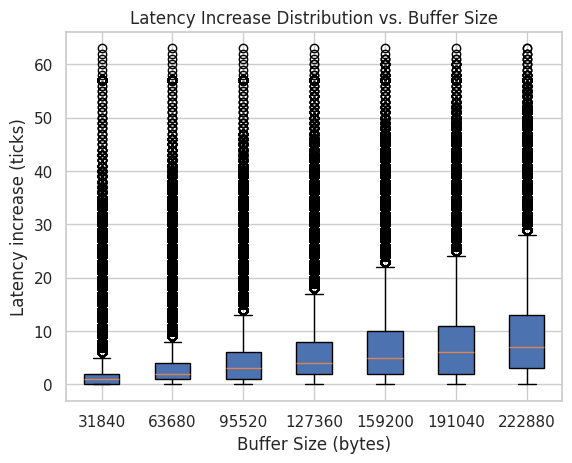

In [15]:
# plot distribution of latencies
# latency_by_buf = { buf_sz: { slot: [latencies], slot2: [latencies] } }
# we want: mblk_wait_by_buf = { buf_sz: [all_latencies], buf_sz2: [all_latencies] }
mblk_wait_by_buf = { buf_sz: [] for buf_sz in buf_szes }
for buf_sz, mblk_wait_by_slot in latency_by_slot_by_buf.items():
    for slot, latencies in mblk_wait_by_slot.items():
        mblk_wait_by_buf[buf_sz].extend(latencies)

sns.set(style="whitegrid")

labels = list(mblk_wait_by_buf.keys())
values = list(mblk_wait_by_buf.values())

# Create the box plot
plt.boxplot(values, labels=labels, vert=True, patch_artist=True)
plt.xlabel('Buffer Size (bytes)')
plt.ylabel('Latency increase (ticks)')
plt.title('Latency Increase Distribution vs. Buffer Size')
plt.show()


## Stat Tests - Mostly useless atm

$H_0: \mu_A \geq \mu_B$

$H_a: \mu_A \le \mu_B$

where A is presumed opt buffer sz (2 * 32 * datasz), and B is other buf szes 

Choose $\alpha = 0.05$

We do multiple pair one-tail t-tests against our ideal buffer size to show that the mean of padding used in buf_size_2 is significantly lower than all the others. Since we conduct multiple t-tests, we should also apply a correction??  Bonferroni is the most common.

In [16]:
import scipy.stats as stats

# perform a one-way, pairwise t-test between the most obviously close buffer sizes
# to see if the difference in padding added is statistically significant

def one_tail_ttest( data1, data2):
    t_stat, p_val = stats.ttest_rel(data1, data2)

    # Convert to one-tailed p-value for H1: muA < muB
    if t_stat < 0:  # Direction of the test
        p_value_1 = p_val / 2
    else:
        p_value_1 = 1 - (p_val / 2)

    print('t-statistic: ', t_stat)
    print('p-value: ', p_value_1)
    return t_stat, p_value_1

def get_buf_padding( buf_sz, padding_by_slot_by_buf):
    return { int(slot) : float(sum(paddings)) for slot, paddings in padding_by_slot_by_buf[buf_sz].items() }

# handwritten loop unrolling :3

buf_1x = get_buf_padding(buf_szes[0], padding_by_slot_by_buf)
buf_2x = get_buf_padding(buf_szes[1], padding_by_slot_by_buf) 
buf_3x = get_buf_padding(buf_szes[2], padding_by_slot_by_buf) 
buf_4x = get_buf_padding(buf_szes[3], padding_by_slot_by_buf)
buf_5x = get_buf_padding(buf_szes[4], padding_by_slot_by_buf)
buf_6x = get_buf_padding(buf_szes[5], padding_by_slot_by_buf)

_, p1 = one_tail_ttest(list(buf_3x.values()), list(buf_1x.values()))
_, p2 = one_tail_ttest(list(buf_3x.values()), list(buf_2x.values()))
_, p3 = one_tail_ttest(list(buf_3x.values()), list(buf_4x.values()))
_, p4 = one_tail_ttest(list(buf_3x.values()), list(buf_5x.values()))
_, p5 = one_tail_ttest(list(buf_3x.values()), list(buf_6x.values()))

p_vals = [p1, p2, p3, p4, p5]

# Apply Bonferroni correction
alpha = 0.05
n_tests = len(p_vals)
alpha_bonf = alpha / n_tests
for p in p_vals:
   if p < alpha_bonf:
       print('Reject null hypothesis')
   else:
       print('Fail to reject null hypothesis')

t-statistic:  -126.8256345924086
p-value:  0.0
t-statistic:  -54.58680386965203
p-value:  0.0
t-statistic:  33.226914761044696
p-value:  1.0
t-statistic:  50.53429963886424
p-value:  1.0
t-statistic:  62.872346922588974
p-value:  1.0
Reject null hypothesis
Reject null hypothesis
Fail to reject null hypothesis
Fail to reject null hypothesis
Fail to reject null hypothesis


Might not be too useful... but this means with buf_sz = 3 * 31840 bytes, we can say that this buf_sz produces statistically .. sigificantly .. lower padding usage than other buf_szes that are multiples of 31840 bytes.

## Analysis Against the Current Scheme (Free Buf Sz)

In [17]:
import math
def payload_per_shred( sz ):
#        Case               payload_bytes_per_shred
#        1 <= D <=  9135               1015
#     8956 <= D <= 31840                995
#    31201 <= D <= 62400                975
#    61121 <= D <= 63984                955
    if sz <= 9135:
        return 1015
    elif sz <= 31840:
        return 995
    elif sz <= 62400:
        return 975
    elif sz <= 63984:
        return 955

def calculate_packing( batch_df, verbose=False):
    """
    Calculating the padding that was used in current scheme, 
    but includes padding out the last batch in a slot to N=32.
    """
    slots = batch_df['slot'].unique()
    slots.sort()
    total_padding_used = 0
    slot_to_padding = {}

    for slot in slots:
        batches = batch_df[batch_df['slot'] == slot]
        slot_padding_used = 0
        for idx, row in batches.iterrows():
            shred_count_total = 0
            # check if last in iteration?
            if idx == batches.index[-1] and row['sz'] < OPT_FEC_SZ:
                # last batch in slot is padded to the the full N=32.
                shred_count_total = 32 
                slot_padding_used += ( OPT_FEC_SZ ) - row['sz']
            else:
                if row['sz'] % OPT_FEC_SZ == 0:                               
                    # case 1: Perfect FEC Sets of N=32
                    slot_padding_used += 0
                    shred_count_total += (row['sz'] / OPT_FEC_SZ) * 32
                elif row['sz'] < 2 * OPT_FEC_SZ:                              
                    # case 2: < 2 * 31840, so we do 1 odd_sized FEC set
                    shred_sz = payload_per_shred( row['sz'] )
                    shred_cnt = math.ceil(row['sz'] / shred_sz) # round up
                    slot_padding_used += (shred_cnt * shred_sz) - row['sz']
                    shred_count_total += shred_cnt
                else:
                    # case 3: > 2 * 31840, so we do N=32 FEC sets until we hit case 2
                    while row['sz'] > 2 * OPT_FEC_SZ:
                        total_padding_used += 0
                        row['sz'] -= OPT_FEC_SZ
                        shred_count_total += 32
                    shred_sz = payload_per_shred( row['sz'] )
                    shred_cnt = math.ceil(row['sz'] / shred_sz)
                    slot_padding_used += (shred_cnt * shred_sz) - row['sz']
                    shred_count_total += shred_cnt
            
            if verbose and row['shred_cnt'] != shred_count_total:
                # Sanity check verifying what we generated in fd_blockstore_ctl
                # matches the shred count we've generated here. We expect the last batch
                # in each slot to mismatch due to the new N=32 padding.
                print('MISMATCH: Shred count total vs. in data: ', shred_count_total, row['shred_cnt'], 'in slot: ', slot, 'batch idx: ', row['ref_tick'])
    
        slot_to_padding[slot] = slot_padding_used
        total_padding_used += slot_padding_used   
                
    return total_padding_used, slot_to_padding

In [18]:
def calculate_latency( microblock_df, verbose=False):
    """
    Calculating the microblock publish wait time in the current scheme.
    """
    slots = microblock_df['slot'].unique()
    slots.sort()
    
    total_latency_increase = 0
    mblk_wait_by_slot = {}  # slot : [ wait_times ]
    negative_latencies = 0
    block_accum_by_slot = {} # slot: ([t1, t2, t3 ... ], [sz1, sz2, ... sz_done]) where time is increasing

    for slot in slots:
        microblocks = microblock_df[microblock_df['slot'] == slot]
        slot_latency_increase = 0
        mblk_wait_by_slot[slot] = []
        block_accum_by_slot[slot] = ([], [])
        accum_sz = 0
        # get the rows of the last microblock in each batch
        # last_in_batches = microblocks.groupby('batch_idx').tail(1)

        for idx, row in microblocks.iterrows():
            sent_tick              = row['ref_tick']
            slot_latency_increase += sent_tick - hashcnt_to_tick(row['hashcnt_adj'])
            mblk_wait_by_slot[slot].append(sent_tick - hashcnt_to_tick(row['hashcnt_adj']))
            accum_sz              += row['sz']

            if( sent_tick < hashcnt_to_tick(row['hashcnt_adj']) ):
                negative_latencies += sent_tick - hashcnt_to_tick(row['hashcnt_adj'])
                #break

            pos_idx = microblocks.index.get_loc(idx)
            if pos_idx + 1 < len(microblocks) and row['batch_idx'] != microblocks.iloc[pos_idx + 1]['batch_idx']:
                # new batch - update block_accum_by_slot
                block_accum_by_slot[slot][0].append(sent_tick)
                block_accum_by_slot[slot][1].append(accum_sz)

        block_accum_by_slot[slot][0].append(sent_tick)
        block_accum_by_slot[slot][1].append(accum_sz)

        mblk_wait_by_slot[slot].append(sent_tick - hashcnt_to_tick(row['hashcnt_adj'])) 
        total_latency_increase += slot_latency_increase

    print('Negative latencies?: ', negative_latencies)
    return total_latency_increase, mblk_wait_by_slot, block_accum_by_slot

In [19]:
total_padding, slot_to_padding_curr = calculate_packing( batch_df, verbose=False )
print( 'Total padding used: ', total_padding, 'bytes' )
print( 'Average zero-padding used per block currently:', total_padding / slot_count, 'bytes' )
print( 'Average zero-padding used per block (w set FEC size N=32, buffer sz = 2x31840):', padding_per_slot[1], 'bytes')
print( '   which is about', padding_per_slot[1] / (total_padding / slot_count), 'x higher')
print( 'Average zero-padding used per block (w set FEC size N=32, buffer sz = 3x31840):', padding_per_slot[2], 'bytes')
print( '   which is about', padding_per_slot[2] / (total_padding / slot_count), 'x higher')
print( 'Average zero-padding used per block (w set FEC size N=32, buffer sz = 4x31840):', padding_per_slot[3], 'bytes')
print( '   which is about', padding_per_slot[3] / (total_padding / slot_count), 'x higher')
print( 'Average zero-padding used per block (w set FEC size N=32, buffer sz = 5x31840):', padding_per_slot[4], 'bytes')
print( '   which is about', padding_per_slot[4] / (total_padding / slot_count), 'x higher')
print( 'Average zero-padding used per block (w set FEC size N=32, buffer sz = 6x31840):', padding_per_slot[5], 'bytes')
print( '   which is about', padding_per_slot[5] / (total_padding / slot_count), 'x higher')
print( 'Average zero-padding used per block (w set FEC size N=32, buffer sz = 7x31840):', padding_per_slot[6], 'bytes')
print( '   which is about', padding_per_slot[6] / (total_padding / slot_count), 'x higher')

print( 'Calculated over', slot_count, 'slots from', batch_df['slot'].min(), 'to', batch_df['slot'].max() )



Total padding used:  163829640.0 bytes
Average zero-padding used per block currently: 33919.1801242236 bytes
Average zero-padding used per block (w set FEC size N=32, buffer sz = 2x31840): 72919.32194616977 bytes
   which is about 2.14979612358301 x higher
Average zero-padding used per block (w set FEC size N=32, buffer sz = 3x31840): 51526.755486542446 bytes
   which is about 1.5191038019738066 x higher
Average zero-padding used per block (w set FEC size N=32, buffer sz = 4x31840): 41129.786542443064 bytes
   which is about 1.2125819784502976 x higher
Average zero-padding used per block (w set FEC size N=32, buffer sz = 5x31840): 35497.887577639754 bytes
   which is about 1.0465432079323376 x higher
Average zero-padding used per block (w set FEC size N=32, buffer sz = 6x31840): 32129.776604554867 bytes
   which is about 0.9472450833683087 x higher
Average zero-padding used per block (w set FEC size N=32, buffer sz = 7x31840): 29353.08757763975 bytes
   which is about 0.865383168759938

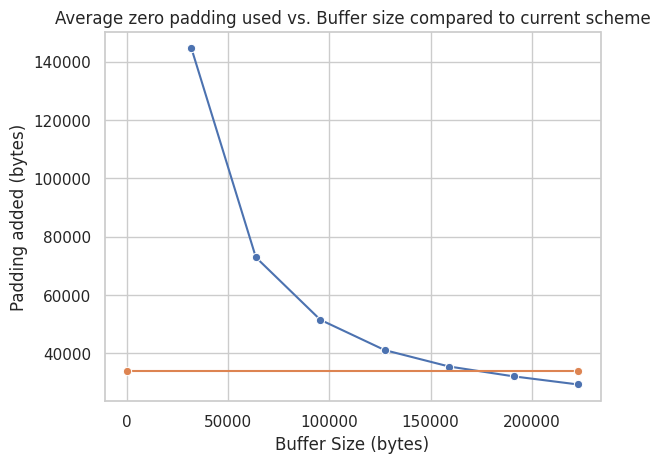

In [20]:
# graph both the current padding and the padding with buf sz on the same graph
sns.set(style="whitegrid")
sns.lineplot(x=buf_szes, y=padding_per_slot, marker='o')
sns.lineplot(x=[0, buf_szes[-1]], y=[total_padding / slot_count, total_padding / slot_count], marker='o')

plt.xlabel('Buffer Size (bytes)')
plt.ylabel('Padding added (bytes)')
plt.title('Average zero padding used vs. Buffer size compared to current scheme')
plt.show()

The current scheme also generates wasted padding - although it is more flexible with FEC set sizes, there is always still space unused in the FEC sets since the payload bytes per shred is a fixed value (due to metadata constraints). In addition, in the future the last FEC set will be padded out to at least 32 shreds, (to prevent a malicious producer from partitioning the network tree successfully ). We can see for 6xOPT_FEC_SZ and 7xOPT_FEC_SZ, the amount of zero padding used drops below the current scheme; as there is almost no wasted space. The entire block is being shredded at once with only zero padding at the end. 

In [21]:
total_latency, mblk_wait_by_slot, block_accum_by_slot = calculate_latency( microblock_df, verbose=False )
print( 'Total latency increase: ', total_latency, 'ticks' )
print( 'Average latency increase per slot currently:', total_latency / slot_count, 'ticks' )
print( 'Average latency increase per slot (w set FEC size N=32, buffer sz = 1x31840):', latency_per_slot[0], 'ticks')
print( '   which is about', latency_per_slot[0] / (total_latency / slot_count), 'x higher')
print( 'Average latency increase per slot (w set FEC size N=32, buffer sz = 2x31840):', latency_per_slot[1], 'ticks')
print( '   which is about', latency_per_slot[1] / (total_latency / slot_count), 'x higher')
print( 'Average latency increase per slot (w set FEC size N=32, buffer sz = 3x31840):', latency_per_slot[2], 'ticks')
print( '   which is about', latency_per_slot[2] / (total_latency / slot_count), 'x higher')
print( 'Average latency increase per slot (w set FEC size N=32, buffer sz = 4x31840):', latency_per_slot[3], 'ticks')
print( '   which is about', latency_per_slot[3] / (total_latency / slot_count), 'x higher')
print( 'Average latency increase per slot (w set FEC size N=32, buffer sz = 5x31840):', latency_per_slot[4], 'ticks')
print( '   which is about', latency_per_slot[4] / (total_latency / slot_count), 'x higher')

Negative latencies?:  0
Total latency increase:  3481854.0 ticks
Average latency increase per slot currently: 720.8807453416149 ticks
Average latency increase per slot (w set FEC size N=32, buffer sz = 1x31840): 888.847619047619 ticks
   which is about 1.2330023027961539 x higher
Average latency increase per slot (w set FEC size N=32, buffer sz = 2x31840): 1583.8902691511387 ticks
   which is about 2.1971599038902836 x higher
Average latency increase per slot (w set FEC size N=32, buffer sz = 3x31840): 2215.110973084886 ticks
   which is about 3.0727842120893065 x higher
Average latency increase per slot (w set FEC size N=32, buffer sz = 4x31840): 2841.011594202899 ticks
   which is about 3.941028543988347 x higher
Average latency increase per slot (w set FEC size N=32, buffer sz = 5x31840): 3443.572049689441 ticks
   which is about 4.776895584938369 x higher


Thist latency measure is microblock wait time in ticks. So since currently microblocks wait ~1.5 ticks in a buffer before being shredded, the latency increases by 2x or 3x are still fairly reasonable. We note that even for the most aggressive shredding (buf_sz = 1x31840), the latency still increases compared to current scheme (although not by much).
This is the expected behavior. As mentioned before, Agave is setting the timer wait for the buffer accumulate enough data for a 32-sized FEC set. When the most recent microblock comes in and overflows the buffer, Agave would have sent out everything in the buffer _including_ the most recent microblock, and then shred that oddly sized batch. This new buffering method in contrast would send out everything in the buffer _before_ the most recent microblock, and save the most recent microblock for the next batch. This is validated by most of the batches in this mainnet dataset being > 32 shreds, and the measured tick latency being less than this new buffering method. 

In other words, Agave would basically shred at the same time that we do, i.e. when the 31840 gets hit, but they would also send the extra microblock whereas we wouldn't.

Then with the additional factor of Agave's timer - if 31840 is not hit within a timer; Agave shreds, while the new buffering scheme would continue to wait. This is fairly rare, but also contributes to the 1.2x latency increase.

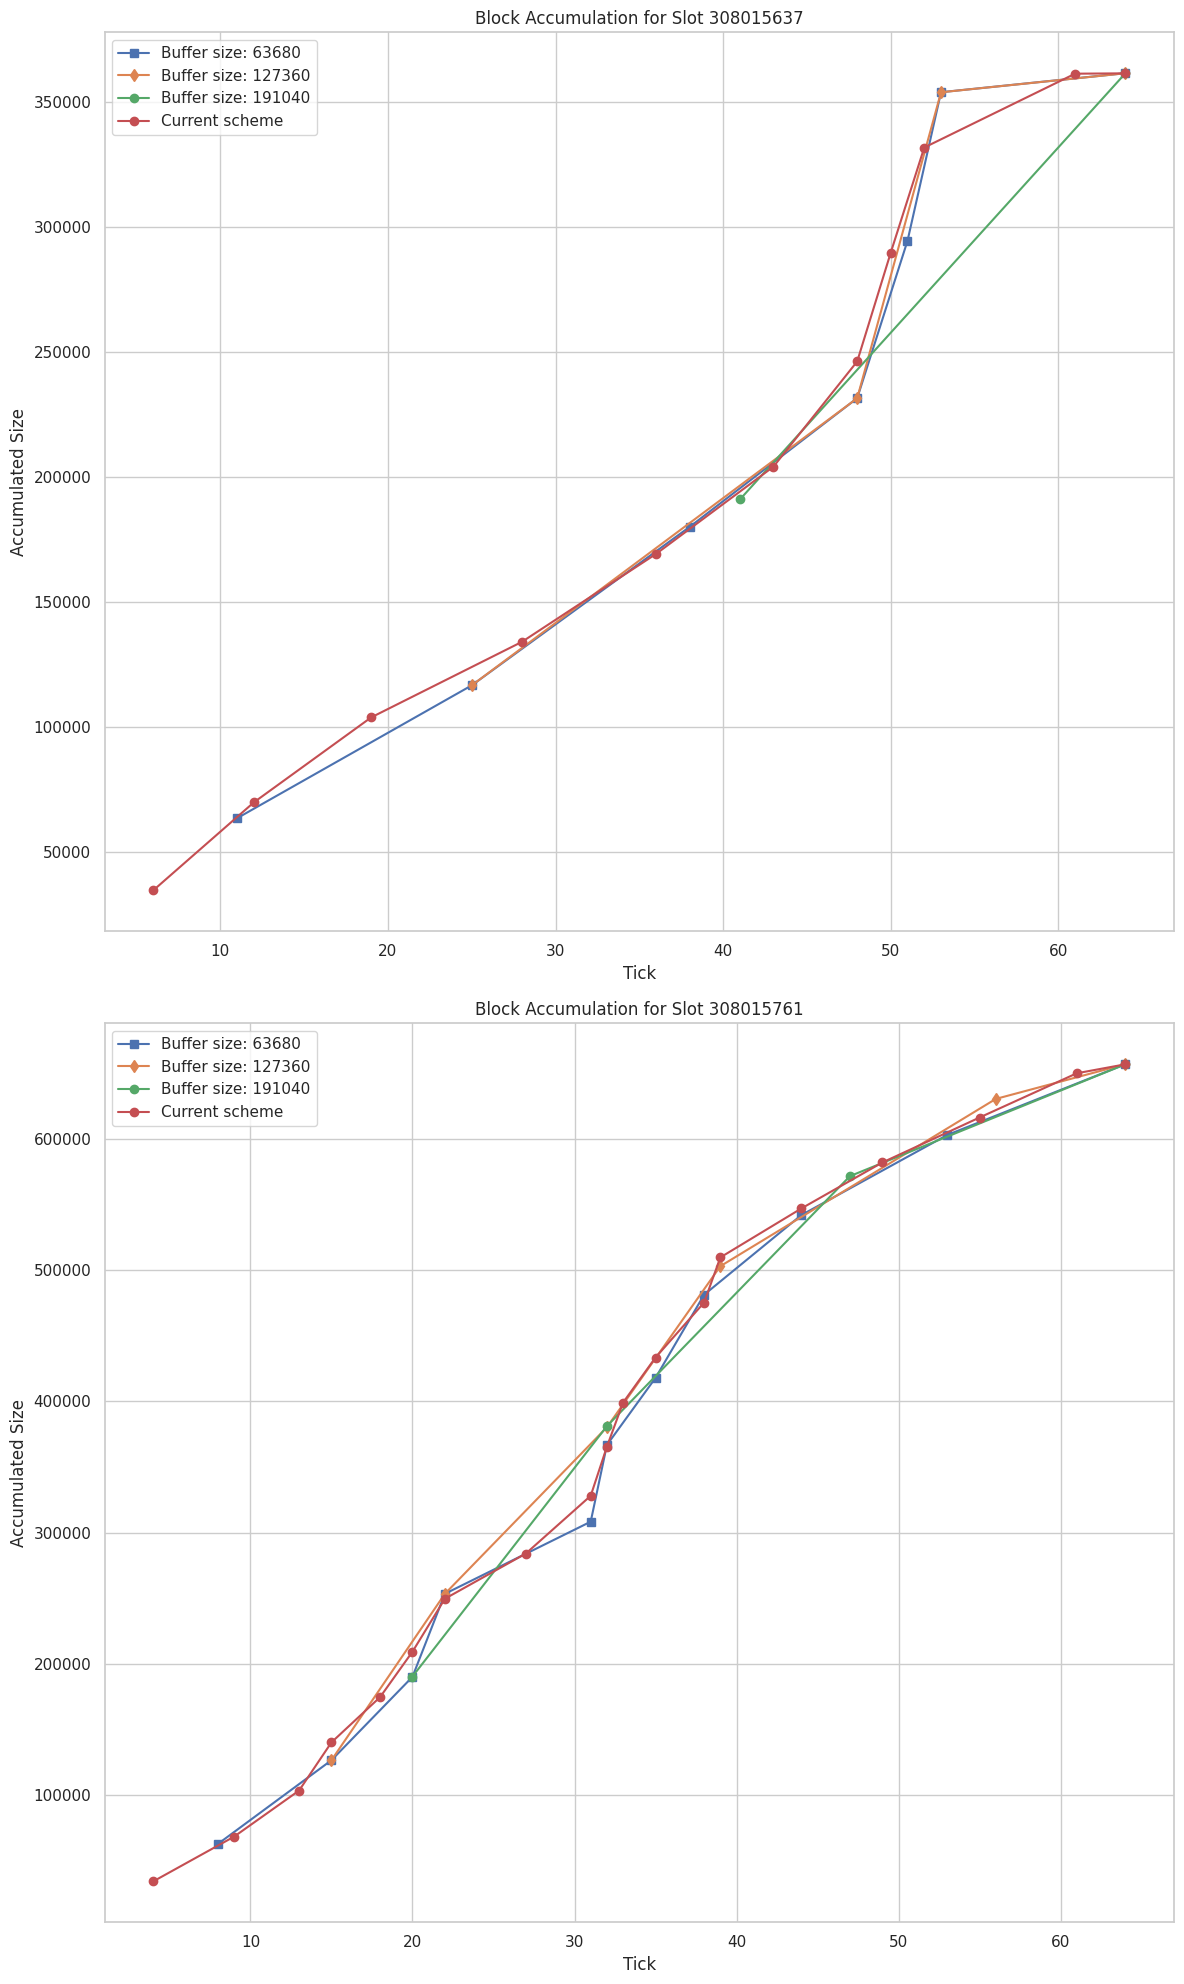

In [22]:
# pick several slots to compare the block accumulation

slots = [308015637, 308015761]#, 308015762, 308015763, 308015764, 308015765, 308015766, 308015767, 308015768, 308015769]

fig, axes = plt.subplots(len(slots), 1, figsize=(12, 10 * len(slots)))  # Adjust figsize for larger plots
axes = axes.flatten() 
markers = ['o', 's', '^', 'd', 'x']  

for i, slot in enumerate(slots):

    for j, buf in enumerate(buf_szes):
        if j % 2 == 0: continue 
        # skip every other buffer size - very cluttered
        axes[i].plot(block_accum_by_slot_by_buf[buf][slot][0], block_accum_by_slot_by_buf[buf][slot][1], marker=markers[j % len(markers)], label=f'Buffer size: {buf}')
    
    axes[i].plot(block_accum_by_slot[slot][0], block_accum_by_slot[slot][1], marker='o', label='Current scheme')
    
    axes[i].set_title(f'Block Accumulation for Slot {slot}')
    axes[i].set_xlabel('Tick')
    axes[i].set_ylabel('Accumulated Size')
    axes[i].legend()

plt.tight_layout()
plt.show()


As expected, for larger buffer sizes, the first batch shreds later and later into the slot, and the jump between batches is much larger. For 308015637, max buf sz, the first batch is not sent until > tick 40. 

The max buf sizes already seem visually unreasonable, but for smaller bufers (2x or 4x), the block accumulation keeps up fairly well with the current scheme.

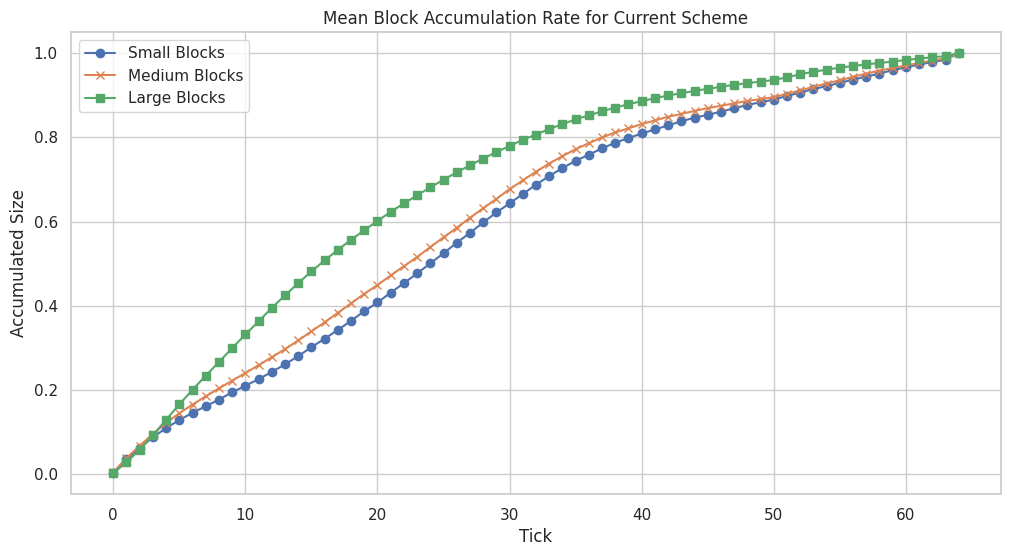

In [23]:
small_blocks = slot_level_info[slot_level_info['sz'] <= block_sz_q1]['slot']
medium_blocks = slot_level_info[(slot_level_info['sz'] > block_sz_q1) & (slot_level_info['sz'] <= block_sz_q2)]['slot']
large_blocks = slot_level_info[slot_level_info['sz'] > block_sz_q2]['slot']

def make_block_cdf( slot, block_accum_by_slot ):
    block_cdf_t  = block_accum_by_slot[slot][0]
    block_cdf_sz = block_accum_by_slot[slot][1]
    max_sz       = block_cdf_sz[-1]

    interpolated_sz = np.zeros(65)
    for idx, t_point in enumerate(block_cdf_t):
        # forward fill the block_cdf_sz
        sz     = block_cdf_sz[idx]
        next_t_point = block_cdf_t[idx + 1] if idx + 1 < len(block_cdf_t) else 65
        percent_sz = sz / max_sz
        for i in range(int(t_point), int(next_t_point)):
            interpolated_sz[i] = percent_sz
    
    return interpolated_sz

def interpolate_mean_block_cdf( slot_list, block_accum_by_slot ):
    t_grid = np.arange( 0, 65 )
    block_cdfs_normalized = []
    for slot in slot_list:
        interpolated_cdf = make_block_cdf( slot, block_accum_by_slot )
        block_cdfs_normalized.append(interpolated_cdf)

    block_cdfs_normalized = np.array(block_cdfs_normalized)
    mean_block_cdf = np.mean(block_cdfs_normalized, axis=0)
    return t_grid, mean_block_cdf

t_grid, curr_mean_small_block_cdf  = interpolate_mean_block_cdf( small_blocks, block_accum_by_slot )
t_grid, curr_mean_medium_block_cdf = interpolate_mean_block_cdf( medium_blocks, block_accum_by_slot )
t_grid, curr_mean_large_block_cdf  = interpolate_mean_block_cdf( large_blocks, block_accum_by_slot )
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.plot(t_grid, curr_mean_small_block_cdf, marker='o', label='Small Blocks')
plt.plot(t_grid, curr_mean_medium_block_cdf, marker='x', label='Medium Blocks')
plt.plot(t_grid, curr_mean_large_block_cdf, marker='s', label='Large Blocks')
plt.legend()
plt.title('Mean Block Accumulation Rate for Current Scheme')
plt.xlabel('Tick')
plt.ylabel('Accumulated Size')
plt.show()


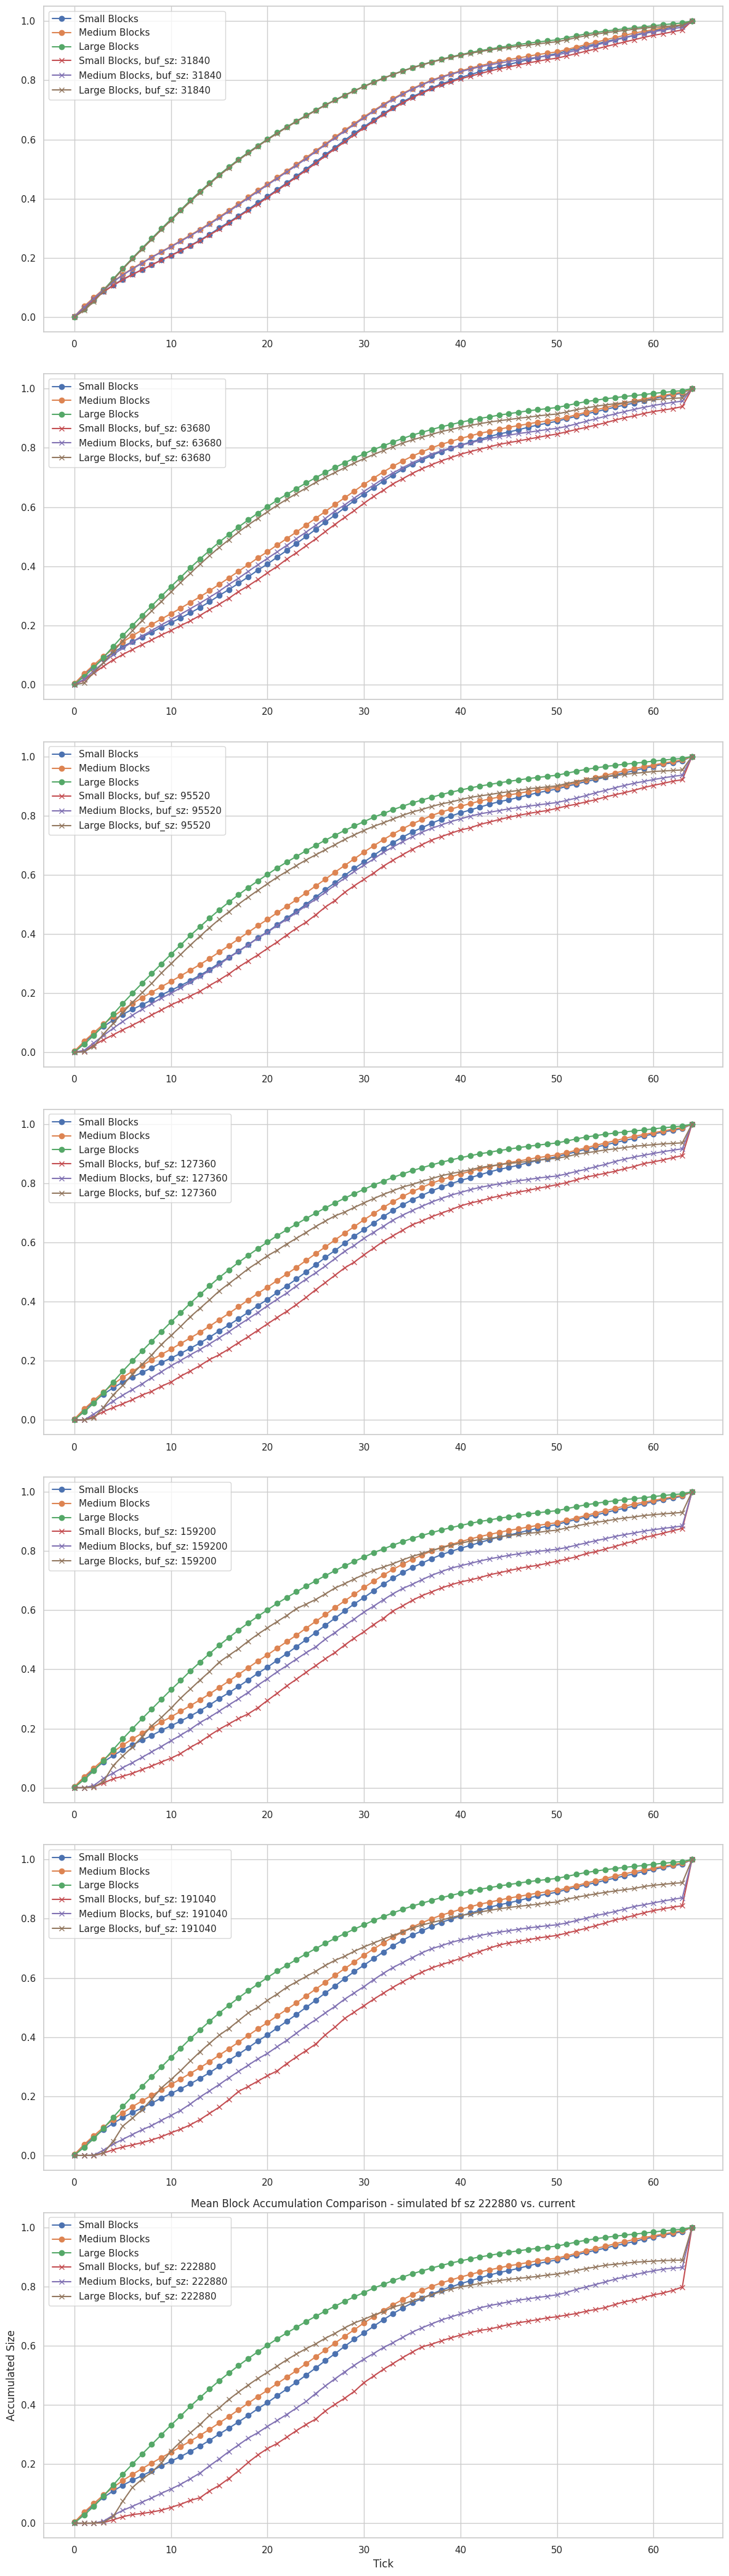

In [24]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(len(buf_szes), 1, figsize=(12, 6 * len(buf_szes)))  # Adjust figsize for larger plots
axes = axes.flatten() 


for i, buf_sz in enumerate(buf_szes):
    axes[i].plot(t_grid, curr_mean_small_block_cdf, marker='o', label='Small Blocks')
    axes[i].plot(t_grid, curr_mean_medium_block_cdf, marker='o', label='Medium Blocks')
    axes[i].plot(t_grid, curr_mean_large_block_cdf, marker='o', label='Large Blocks')

    blk_accum_by_slot = block_accum_by_slot_by_buf[buf_sz]
    t_grid, mean_small_block_cdf  = interpolate_mean_block_cdf( small_blocks, blk_accum_by_slot )
    t_grid, mean_medium_block_cdf = interpolate_mean_block_cdf( medium_blocks, blk_accum_by_slot )
    t_grid, mean_large_block_cdf  = interpolate_mean_block_cdf( large_blocks, blk_accum_by_slot )

    axes[i].plot(t_grid, mean_small_block_cdf, marker='x', label=f'Small Blocks, buf_sz: {buf_sz}')
    axes[i].plot(t_grid, mean_medium_block_cdf, marker='x', label=f'Medium Blocks, buf_sz: {buf_sz}')
    axes[i].plot(t_grid, mean_large_block_cdf, marker='x', label=f'Large Blocks, buf_sz: {buf_sz}')

    axes[i].legend()
    plt.title(f'Mean Block Accumulation Comparison - simulated bf sz {buf_sz} vs. current')
    plt.xlabel('Tick')
    plt.ylabel('Accumulated Size')

plt.tight_layout()
plt.show()

As buffer size increases, the amount of catchup that the new buffering scheme needs to do at the end greatly increases. We compare these numerically below:

In [25]:
# Compare the ticks of when 90% of the block gets sent out

# find first idx where block_cdf_sz >= 0.9

def find_nth_percent_sent( blck_cdf, n):
    for idx, sz in enumerate(blck_cdf):
        if sz >= n:
            return idx
    assert False
    return -1  # should never hit

# averages CDF first, then finds the tick
print('Current scheme: 50% of medium-sized blocks sent by tick: ', find_nth_percent_sent( curr_mean_medium_block_cdf, 0.5))
print('Current scheme: 90% of medium-sized blocks sent by tick: ', find_nth_percent_sent( curr_mean_medium_block_cdf, 0.9))

for buf_sz in [ 1, 2, 3, 4, 5 ]:
    t_grid, mean_medium_block_cdf = interpolate_mean_block_cdf( medium_blocks, block_accum_by_slot_by_buf[buf_sz * OPT_FEC_SZ] )
    print(f'Buffer size {buf_sz}*31840: 50% of medium-sized blocks sent by tick: ', find_nth_percent_sent( mean_medium_block_cdf, 0.5 ))
    print(f'Buffer size {buf_sz}*31840: 90% of medium-sized blocks sent by tick: ', find_nth_percent_sent( mean_medium_block_cdf, 0.9 ))

print("\n")

## averages the tick PER SLOT -- not averaging the CDF first.
# current scheme
percentiles = ['25th', '50th', '75th', '90th', '99th']
ps = [0.25, 0.5, 0.75, 0.9, 0.99]
columns = ['slot'] + percentiles

curr_cdf_by_slot = pd.DataFrame( columns=columns )
#buf1x_cdf_by_slot = pd.DataFrame( columns=columns )
#buf2x_cdf_by_slot = pd.DataFrame( columns=columns )
#buf3x_cdf_by_slot = pd.DataFrame( columns=columns )
#buf4x_cdf_by_slot = pd.DataFrame( columns=columns )
#buf5x_cdf_by_slot = pd.DataFrame( columns=columns )
buf_cdf_by_slot = { n : pd.DataFrame( columns=columns ) for n in range(1, 6) }

for slot in medium_blocks:
    curr_medium_block_cdf = make_block_cdf( slot, block_accum_by_slot )
    curr_cdf_by_slot.loc[len(curr_cdf_by_slot)] = [ slot ] + [ find_nth_percent_sent( curr_medium_block_cdf, p ) for p in [0.25, 0.5, 0.75, 0.9, 0.99] ]

    for n in range(1, 6):
        med_block_cdf = make_block_cdf( slot, block_accum_by_slot_by_buf[n*OPT_FEC_SZ] )
        buf_cdf_by_slot[n].loc[len(buf_cdf_by_slot[n])] = [ slot ] +  [ find_nth_percent_sent( med_block_cdf, p ) for p in ps ]


print('Current scheme: 50th percentile of medium-sized blocks sent by tick: ', curr_cdf_by_slot['50th'].mean())
print('Current scheme: 90th percentile of medium-sized blocks sent by tick: ', curr_cdf_by_slot['90th'].mean())
print('Buffer size 1x: 50th percentile of medium-sized blocks sent by tick: ', buf_cdf_by_slot[1]['50th'].mean())
print('Buffer size 1x: 90th percentile of medium-sized blocks sent by tick: ', buf_cdf_by_slot[1]['90th'].mean())
print('Buffer size 2x: 50th percentile of medium-sized blocks sent by tick: ', buf_cdf_by_slot[2]['50th'].mean())
print('Buffer size 2x: 90th percentile of medium-sized blocks sent by tick: ', buf_cdf_by_slot[2]['90th'].mean())
print('Buffer size 3x: 50th percentile of medium-sized blocks sent by tick: ', buf_cdf_by_slot[3]['50th'].mean())
print('Buffer size 3x: 90th percentile of medium-sized blocks sent by tick: ', buf_cdf_by_slot[3]['90th'].mean())
print('Buffer size 4x: 50th percentile of medium-sized blocks sent by tick: ', buf_cdf_by_slot[4]['50th'].mean())
print('Buffer size 4x: 90th percentile of medium-sized blocks sent by tick: ', buf_cdf_by_slot[4]['90th'].mean())
print('Buffer size 5x: 50th percentile of medium-sized blocks sent by tick: ', buf_cdf_by_slot[5]['50th'].mean())
print('Buffer size 5x: 90th percentile of medium-sized blocks sent by tick: ', buf_cdf_by_slot[5]['90th'].mean())




Current scheme: 50% of medium-sized blocks sent by tick:  23
Current scheme: 90% of medium-sized blocks sent by tick:  51
Buffer size 1*31840: 50% of medium-sized blocks sent by tick:  23
Buffer size 1*31840: 90% of medium-sized blocks sent by tick:  52
Buffer size 2*31840: 50% of medium-sized blocks sent by tick:  24
Buffer size 2*31840: 90% of medium-sized blocks sent by tick:  55
Buffer size 3*31840: 50% of medium-sized blocks sent by tick:  25
Buffer size 3*31840: 90% of medium-sized blocks sent by tick:  57
Buffer size 4*31840: 50% of medium-sized blocks sent by tick:  26
Buffer size 4*31840: 90% of medium-sized blocks sent by tick:  60
Buffer size 5*31840: 50% of medium-sized blocks sent by tick:  26
Buffer size 5*31840: 90% of medium-sized blocks sent by tick:  64


Current scheme: 50th percentile of medium-sized blocks sent by tick:  22.40182270091135
Current scheme: 90th percentile of medium-sized blocks sent by tick:  48.527340513670254
Buffer size 1x: 50th percentile of medi

First set of numbers calculates the CDF of each block/slot, then averages it, and then gets the tick percentile.

Second set of numbers calculats the CDF of each block/slot, gets the tick percentile, and then averages the tick.

Not sure which one is pseudoscience.

But interestingly enough, for buffer size 5x and above, we need to wait until tick 64 to send out the last 10% of the block - and possibly even the last 25%. Compared to the current scheme that has 90% of the block sent out by tick 51, this is cutting it close. However up to
buf 4x or 3x, there is still a fair good amount of leeway.

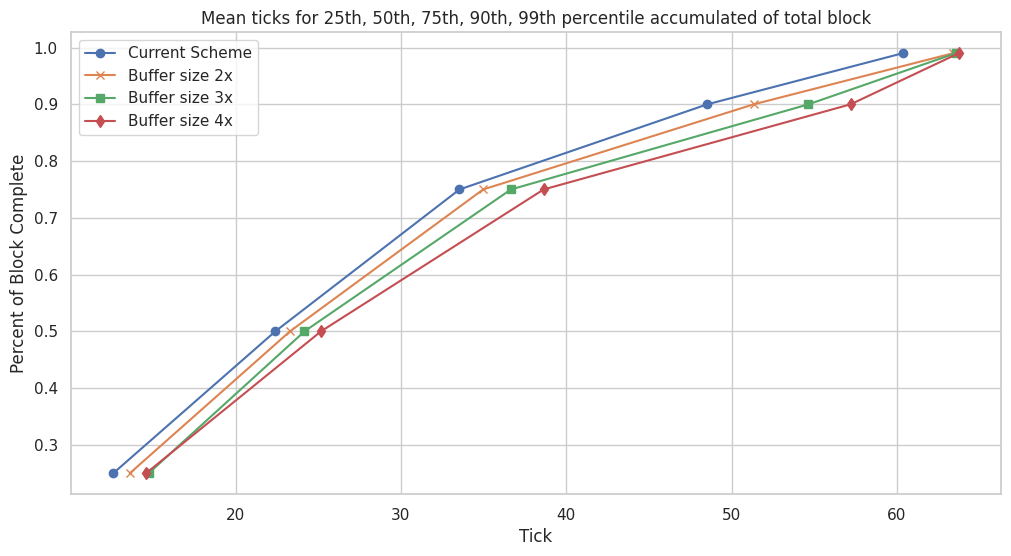

   scheme       25th       50th       75th       90th       99th
0    curr  12.600663  22.401823  33.540597  48.527341  60.345070
1  2x buf  13.601491  23.287904  34.971831  51.335543  63.388981
2  3x buf  14.739022  24.166114  36.652444  54.646645  63.552196
3  4x buf  14.584507  25.164043  38.628418  57.195112  63.738194


In [26]:
# plot the mean ticks for 50th and 90th percentile of medium-sized blocks
accum = [0.25, 0.5, 0.75, 0.9, 0.99]
curr = [ curr_cdf_by_slot[p].mean() for p in percentiles ]
buf2x = [ buf_cdf_by_slot[2][p].mean() for p in percentiles ]
buf3x = [ buf_cdf_by_slot[3][p].mean() for p in percentiles ]
buf4x = [ buf_cdf_by_slot[4][p].mean() for p in percentiles ]

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.plot(curr, accum, marker='o', label='Current Scheme')
plt.plot(buf2x, accum, marker='x', label='Buffer size 2x')
plt.plot(buf3x, accum, marker='s', label='Buffer size 3x')
plt.plot(buf4x, accum, marker='d', label='Buffer size 4x')
plt.legend()
plt.title('Mean ticks for 25th, 50th, 75th, 90th, 99th percentile accumulated of total block')
plt.xlabel('Tick')
plt.ylabel('Percent of Block Complete')
plt.show()

readable = pd.DataFrame( columns=['scheme'] + percentiles )
readable.loc[0] = ['curr'] + curr
readable.loc[1] = ['2x buf'] + buf2x
readable.loc[2] = ['3x buf'] + buf3x
readable.loc[3] = ['4x buf'] + buf4x
print(readable)


Slot with the biggest jump at the end:  308017269 with jump of:  95504.0


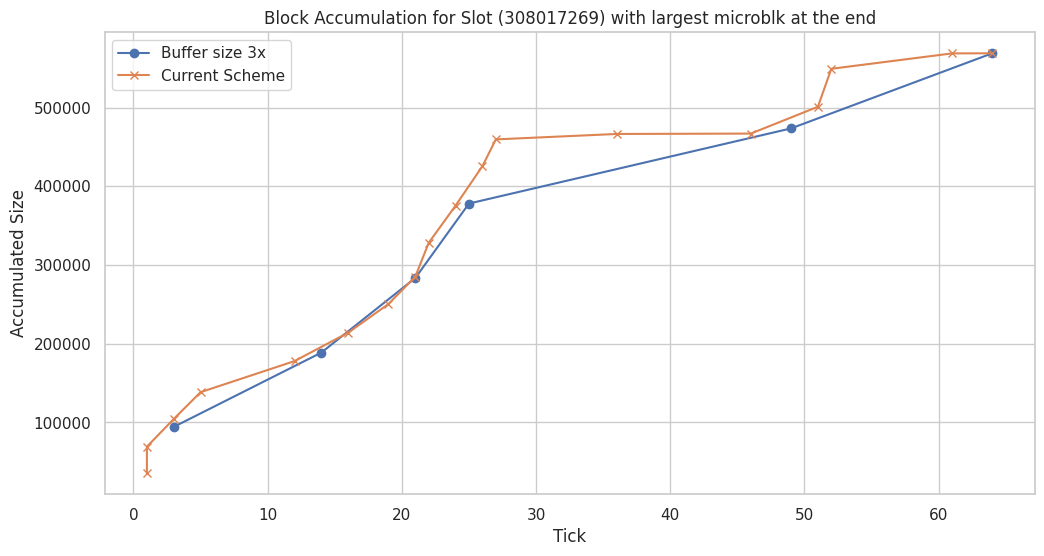

In [27]:
# find the block with the biggest jump at the end

slot_with_max_jump = 0
max_jump = 0
for slot in batch_df['slot'].unique():
    block_accum = block_accum_by_slot_by_buf[ 3* OPT_FEC_SZ ][slot][1]
    if len(block_accum) < 2: continue
    if block_accum[-1] - block_accum[-2] > max_jump:
        slot_with_max_jump = slot
        max_jump = block_accum[-1] - block_accum[-2]

print('Slot with the biggest jump at the end: ', slot_with_max_jump, 'with jump of: ', max_jump)

# plot the block accumulation for the slot with the biggest jump
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.plot(block_accum_by_slot_by_buf[3*OPT_FEC_SZ][slot_with_max_jump][0], block_accum_by_slot_by_buf[3*OPT_FEC_SZ][slot_with_max_jump][1], marker='o', label='Buffer size 3x')
plt.plot(block_accum_by_slot[slot_with_max_jump][0], block_accum_by_slot[slot_with_max_jump][1], marker='x', label='Current Scheme')
plt.title(f'Block Accumulation for Slot ({slot_with_max_jump}) with largest microblk at the end')
plt.legend()
plt.xlabel('Tick')
plt.ylabel('Accumulated Size')
plt.show()


We want to verify that even with a larger buffer size, we aren't sending half of the block at tick 64. So we check for the largest jump in the CDF for the buffer size 3x (as an example large buf sz) and compare it to how the current scheme is accumulating the block.
We can see that out of our entire data set, using buffer size 3x, the largest last batch is size 95504 Bytes, which is about 15% of the block, and is accumulating starting from around tick 50.

Seems reasonable I think. Maybe needs some more clarity though.

## Stats Test doing set buf sz vs. current scheme

In [28]:
"""
Unhelpful stuff
"""
_, p = one_tail_ttest(list(slot_to_padding_curr.values()), list(buf_3x.values()))

assert(slot_to_padding_curr.keys() == buf_3x.keys())
## average every 10 values for better readability
sorted_slots = sorted(slot_to_padding_curr.keys())
avg_n_curr = {}
avg_n_opt  = {}
stride = 100
for i in range(0, len(sorted_slots), stride):
    avg_curr = np.mean(list(slot_to_padding_curr.values())[i:i+stride])
    avg_opt  = np.mean(list(buf_3x.values())[i:i+stride])
    avg_n_curr[i] = avg_curr
    avg_n_opt[i] = avg_opt

print(i)

# graph padding per slot of current scheme vs. optimal buffer size
# TODO: remove this, not very useful
# sns.set(style="whitegrid")

# sns.lineplot(x=avg_n_curr.keys(), y=avg_n_curr.values(), marker='o', label='Current Scheme')
# sns.lineplot(x=avg_n_opt.keys(), y=avg_n_opt.values(), marker='o', label='w/ Optimal Buffer Size')
# plt.xlabel('Slot')
# plt.ylabel('Padding added (bytes)')
# plt.title('Padding added per slot: Current vs. Optimal Buffer Size')
# plt.legend()
# plt.show()


t-statistic:  -51.07177507600887
p-value:  0.0
4800


## Conclusion
Optimal Size ... idk

[np.float64(1.0), np.float64(0.37828822264990736), np.float64(0.1925352866610654), np.float64(0.10225778253849957), np.float64(0.05335566647500415), np.float64(0.024110157145047297), np.float64(0.0)]
[0.0, 0.18867153401504985, 0.36001839811828434, 0.5299211088508122, 0.693488057521546, 0.8455762461948785, 1.0]


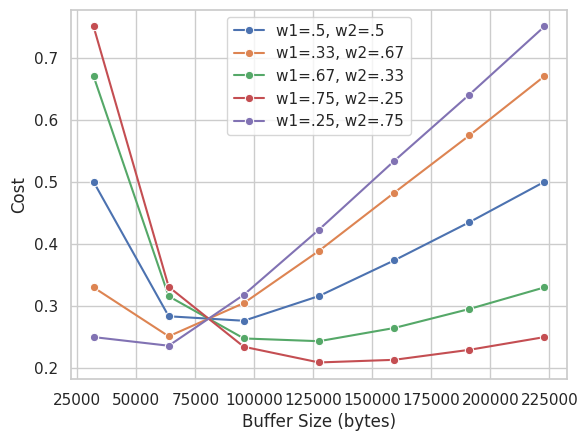

Using equal weighting on padding and latency, the optimal buffer size is: 95520 with cost 0.27627684238967487


In [29]:

# Equal weights for padding and latency
# plot of cost function at different weights

w1 = 1  # Weight for padding
w2 = 1  # Weight for latency

def min_max_normalize(lst):
    return [(x - min(lst)) / (max(lst) - min(lst)) for x in lst]

# Define the cost function
def cost_function(buf_size, padding, latency, w_pad=1, w_latency=1):
    idx = buf_szes.index(buf_size)
    pad = padding[idx]
    lat = latency[idx]
    return w_pad * pad + w_latency * lat

# Normalize the padding and latency values
padding_lst_norm = min_max_normalize(bufs_padding_lst)
latency_lst_norm = min_max_normalize(bufs_latency_lst)
print(padding_lst_norm)
print(latency_lst_norm)

# TODO: narrow down weights, and do a for-loop
costs1 = [cost_function(size, padding_lst_norm, latency_lst_norm, w_pad=0.5, w_latency=0.5) for size in buf_szes]
costs2 = [cost_function(size, padding_lst_norm, latency_lst_norm, w_pad=0.33, w_latency=0.67) for size in buf_szes]
costs3 = [cost_function(size, padding_lst_norm, latency_lst_norm, w_pad=0.67, w_latency=0.33) for size in buf_szes]
costs4 = [cost_function(size, padding_lst_norm, latency_lst_norm, w_pad=0.75, w_latency=0.25) for size in buf_szes]
costs5 = [cost_function(size, padding_lst_norm, latency_lst_norm, w_pad=0.25, w_latency=0.75) for size in buf_szes]

# plot cost functions on same graph
sns.set(style="whitegrid")
sns.lineplot(x=buf_szes, y=costs1, marker='o', label='w1=.5, w2=.5')
sns.lineplot(x=buf_szes, y=costs2, marker='o', label='w1=.33, w2=.67')
sns.lineplot(x=buf_szes, y=costs3, marker='o', label='w1=.67, w2=.33')
sns.lineplot(x=buf_szes, y=costs4, marker='o', label='w1=.75, w2=.25')
sns.lineplot(x=buf_szes, y=costs5, marker='o', label='w1=.25, w2=.75')
plt.ylabel('Cost')
plt.xlabel('Buffer Size (bytes)')
plt.show()

optimal_size = buf_szes[np.argmin(costs1)]

print(f"Using equal weighting on padding and latency, the optimal buffer size is: {optimal_size} with cost {min(costs1)}")


/tmp/ipykernel_960583/677970034.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([buf_mblk_waits, current_mblk_waits], labels=[f'buf sz = {best_buf_sz}', 'current'], vert=True, patch_artist=True)


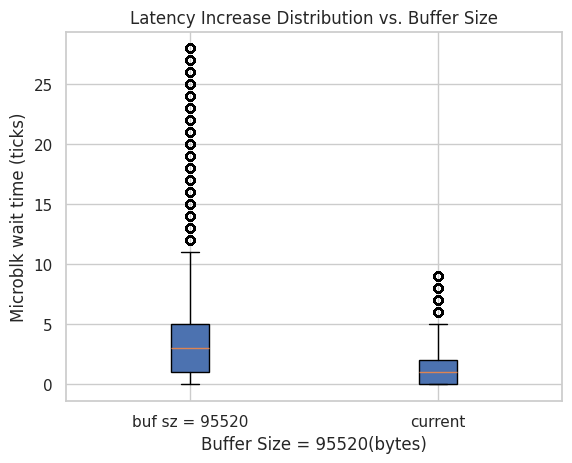

On average we are increasing the time microblocks wait to get sent by:  2.956430316749393 ticks
for 3x buf:  4.4209290883823025 vs. current:  1.4644987716329094
Second latency measurement - how the ticks at which 25% of the block, 50% of the block, etc. are sent out compare between the current scheme and the optimal buffer size
   scheme       25th       50th       75th       90th       99th
0    curr  12.600663  22.401823  33.540597  48.527341  60.345070
2  3x buf  14.739022  24.166114  36.652444  54.646645  63.552196


In [30]:
# plot distribution of latencies against current
# there's so many upper outliers that it's hard to see the distribution
# so we'll filter out the upper outliers


best_buf_sz = buf_szes[2] # change as needed
sns.set(style="whitegrid")

current_mblk_waits = []
for slot, latencies in mblk_wait_by_slot.items():
    current_mblk_waits.extend(latencies)

buf_mblk_waits = np.array(mblk_wait_by_buf[ best_buf_sz ])
current_mblk_waits = np.array(current_mblk_waits)

# filter outliers using quantile
upper_bound = np.quantile(current_mblk_waits, 0.99)
current_mblk_waits = current_mblk_waits[(current_mblk_waits <= upper_bound)]

upper_bound = np.quantile(buf_mblk_waits, 0.99)
buf_mblk_waits = buf_mblk_waits[(buf_mblk_waits <= upper_bound)]

# Create the box plot
plt.boxplot([buf_mblk_waits, current_mblk_waits], labels=[f'buf sz = {best_buf_sz}', 'current'], vert=True, patch_artist=True)
plt.xlabel(f'Buffer Size = {best_buf_sz}(bytes)')
plt.ylabel('Microblk wait time (ticks)')
plt.title('Latency Increase Distribution vs. Buffer Size')
plt.show()

print("On average we are increasing the time microblocks wait to get sent by: ", np.mean(buf_mblk_waits) - np.mean(current_mblk_waits), "ticks")
print("for 3x buf: ", np.mean(buf_mblk_waits), "vs. current: ", np.mean(current_mblk_waits), "\n")

print("Second latency measurement - how the ticks at which 25% of the block, 50% of the block, etc. are sent out compare between the current scheme and the optimal buffer size")
readable = pd.DataFrame( columns=['scheme'] + percentiles )
readable.loc[0] = ['curr'] + curr
readable.loc[1] = ['3x buf'] + buf3x
print(readable)

In [42]:
print( 'Average zero-padding used per block (w set FEC size N=32, buffer sz = 3x31840):', padding_per_slot[2], 'bytes')
print( '   which is about', padding_per_slot[2] / (total_padding / slot_count), 'x higher than the current scheme')

# percentage of padding per block: 
block_sizes = batch_df.groupby('slot')['sz'].sum()
opt_padding_by_slot = padding_by_slot_by_buf[best_buf_sz]
opt_padding_by_slot = { slot: sum(paddings) for slot, paddings in opt_padding_by_slot.items() }
padding_percent_per_block = [ ( total_padding / (total_padding + block_sizes[slot])) * 100 for slot, total_padding in opt_padding_by_slot.items() ]
print('Which means ', np.mean(padding_percent_per_block), '% of the block is zero-padding (on average)')

Average zero-padding used per block (w set FEC size N=32, buffer sz = 3x31840): 51526.755486542446 bytes
   which is about 1.5191038019738066 x higher than the current scheme
Which means  5.886570799146406 % of the block is zero-padding (on average)


So it's not that bad :D fixed FEC sets for the win!  🎉